# Interpolação por Spline Cúbica

A interpolação por Spline cúbico corresponde a um método de interpolação, consiste na construção de uma conjunto de pontos continuo por meio da existência de um conjunto de pontos discreto, utilizando polinômios de terceiro grau.

# Definição

a função spline $S(x)$ consiste de uma função por partes, onde assumindo a existência de $n$ pontos na forma $(x_{i},y_{i})$ sendo $i=0,1,2,\ldots,n-1$ e ordenados de forma crescente $x_{0}\leq x_{1} \leq \ldots \leq x_{i}\leq\ldots\leq x_{i}$.  
Onde a função que modela o subintervalo $[x_{i},x_{i+1}]$ é da forma $s_{i}(x)=a_{i}+b_{i}(x-x_{i})+c_{i}(x-x_{i})^{2}+d_{i}(x-x_{i})^{3}$, sendo constantes $a_{i},b_{i},c_{i}$ e $d_{i}$ tal que $d_{i}\neq0$.

$S(x)=\begin{cases}
s_{0} = a_{0}+b_{0}(x-x_{0})+c_{0}(x-x_{i})^{2}+d_{0}(x-x_{i})^{3} & x_{0}\leq x \leq x_{1} \\
\ldots & \ldots \\
s_{i} = a_{i}+b_{i}(x-x_{0})+c_{i}(x-x_{i})^{2}+d_{i}(x-x_{i})^{3} & x_{i-1}\leq x \leq x_{i} \\
\ldots & \ldots \\
s_{n-1} = a_{n-1}+b_{n-1}(x-x_{0})+c_{n-1}(x-x_{i})^{2}+d_{n-1}(x-x_{i})^{3} & x_{n-2}\leq x \leq x_{n-1}
\end{cases}$

# Observação

Destamos que poderiamos recorrer diretamente a biblioteca [scipy](https://scipy.org/) por contém o método `scipy.interpolate.CubicSpline` que opera diretamente com esse método de interpolação. Recorre o scipy para modelagem desse tipo de interpolação se mostra muito mais eficiente em diverso níveis, diverso modelos de spline e velocidade no processamento, esse notebook trata somente de uma dos métodos de interpolação por Spline Cúbica de condição natural.

# Bibliotecas

In [33]:
#Bibliotecas utilizadas
import matplotlib.pyplot as plt
import numpy as np

In [34]:
import matplotlib
print(f'Versão do Matplotlib: {matplotlib.__version__}')
print(f'Versão do numpy: {np.__version__}')

Versão do Matplotlib: 3.6.3
Versão do numpy: 1.24.1


# Funções

## Coeficientes da Matriz de solução

Função que constroi a matriz dos coeficientes, os coeficientes são as constantes associadas a cada função $s_{i}$

* Condição - 1
> $S_{0}(x_{0}) = y_{0}$  
$S_{i}(x_{i}) = y_{i}$

* Condição - 2
> $S_{0}(x_{i}) = y_{i}$  
$S_{i}(x_{i+1}) = y_{i+1}$

* Condição - 3
> $S_{0}^{'}(x_{i}) = S_{i}^{'}(x_{i})$

* Condição - 4
> $S_{0}^{''}(x_{i}) = S_{i}^{''}(x_{i})$

* Condição - 5 (Condição Natural)
> $S_{0}^{''}(x_{0}) = 0$  
$S_{n-1}^{''}(x_{n}) = 0$

In [35]:
#Coeficientes da matriz
def coeficientes(x = []):
    #Número de equações
    n_equacao = len(x) - 1
    
    #Matriz dos coeficientes
    coeficientes = []
    
    #Condição I
    i = 1
    j = 0
    while i <= n_equacao:
        k = [0 for i in range(4*n_equacao)]
        k[j] = 1
        
        coeficientes.append(k)
        
        j += 4
        i += 1
    
    #Condição II
    i = 0
    j = 0
    while i < n_equacao:
        k = [0 for i in range(4*n_equacao)]
        k[j]  = 1
        k[j+1] = x[i+1] - x[i]
        k[j+2] = (x[i+1] - x[i])**2
        k[j+3] = (x[i+1] - x[i])**3
        coeficientes.append(k)
        j += 4
        i += 1
    
    #Condição III
    i = 0
    j = 0
    while i < n_equacao - 1:
        k = [0 for i in range(4*n_equacao)]
        k[j+1] = 1
        k[j+2] = 2*(x[i+1] - x[i])
        k[j+3] = 3*(x[i+1] - x[i])**2
        k[j+5] = -1
        coeficientes.append(k)
        j += 4
        i += 1
    
    #Condição IV
    i = 0
    j = 0
    while i < n_equacao-1:
        k = [0 for i in range(4*n_equacao)]
        k[j+2] = 2
        k[j+3] = 6*(x[i+1] - x[i])
        k[j+6] = -2
        
        if i < n_equacao -1:
            coeficientes.append(k)
        
        j += 4
        i += 1
    
    #Condição V
    i = 0
    j = 0
    while i < n_equacao:
        k = [0 for i in range(4*n_equacao)]
        if i == 0:
            k[j+2] = 2
            k[j+3] = 0
            coeficientes.append(k)
        if i == n_equacao - 1:
            k[j+2] = 2
            k[j+3] = 6*(x[i+1] - x[i])
            coeficientes.append(k)
        j += 4
        i += 1
    
    return coeficientes

In [36]:
coeficientes(x=[1,2,3])

[[1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 1, 1],
 [0, 1, 2, 3, 0, -1, 0, 0],
 [0, 0, 2, 6, 0, 0, -2, 0],
 [0, 0, 2, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 2, 6]]

## Matriz com resultados dos coeficientes

Função que constroi a matriz dos termos independentes

In [37]:
def r(y = []):
    #Número de equações
    n_equacoes = len(y) - 1
    
    #Lista com resultados não nulos
    z = [y[i] for i in range(len(y)-1)] + [y[i] for i in range(len(y)) if i >= 1]
    
    #complementado a lista para solução do sistema matricial
    for i in range(4*n_equacoes - len(z)):
        z.append(0)
    
    return z

In [38]:
r([1,2,3])

[1, 2, 2, 3, 0, 0, 0, 0]

# Solução dos sistema

A solução do sistema matricial utilizaremos a biblioteca [numpy](https://numpy.org/) por meio da função [numpy.linalg.solve](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve) para soluçaõ do sistema matricial

In [39]:
#Unido tudo todas etapas anteriores em uma unica função
def solucao(x = [], y = []):
    
    #Matriz dos coeficientes
    A = coeficientes(x)
    
    #Matriz dos termos independentes
    b = r(y)
    
    #Solução pelo numpy
    solve = np.linalg.solve(A,b)
    l2 = [i for i in solve]
    
    return l2

In [40]:
solucao(x = [1, 2, 3], y = [2, 3, 5])

[2.0, 0.75, 0.0, 0.25, 3.0, 1.5, 0.75, -0.25]

# Função Spline Cúbica Geral

In [41]:
#Criando o implemento da função para calculo de uma valor
def Spline_Cubica(x = [], y = [], **kwargs):
    
    #Coeficientes do spline cubica
    coeficientes = solucao(x,y)
    
    #Mostra os coeficientes
    Coef = kwargs.get('coeficientes')
    if Coef == True:
        return coeficientes
    
    #Determinação do valor de um spline 
    valor = kwargs.get('valor')
    
    if valor != None:
        #Determinação dos coeficientes a serem utilizados
        count = 0
        while count < len(x):
            if count == len(x) - 2:
                break
            if valor <= x[count]:
                break
            if x[count] < valor <= x[count+1]:
                break
            count += 1
        
        #resultados
        s0 = coeficientes[4*count + 0]
        s1 = coeficientes[4*count + 1]*(valor - x[count])
        s2 = coeficientes[4*count + 2]*(valor - x[count])**2
        s3 = coeficientes[4*count + 3]*(valor - x[count])**3
        
        #Valor do Spline para valor
        s = s0 + s1 + s2 + s3 
        
        return s

# Pontos arbitrários

Consideramos os seguintes pontos $(0,0), (1,5), (2,2.5)$ e $(3,9)$.

In [42]:
#Sem retorno
Spline_Cubica(x = [0,1,2,3],
              y = [0,5,2.5,9],
              coeficientes = False,
              valor = None)

In [43]:
#Retorna os coeficientes
Spline_Cubica(x = [0,1,2,3],
              y = [0,5,2.5,9],
              coeficientes = True,
              valor = None)

[0.0,
 7.6,
 0.0,
 -2.6,
 5.000000000000001,
 -0.20000000000000107,
 -7.800000000000001,
 5.500000000000001,
 2.5,
 0.6999999999999993,
 8.700000000000003,
 -2.9000000000000012]

In [44]:
#Retorna o valor estimado para x = 2.2
Spline_Cubica(x = [0,1,2,3],
              y = [0,5,2.5,9],
              coeficientes = False,
              valor = 2.2)

2.9648000000000008

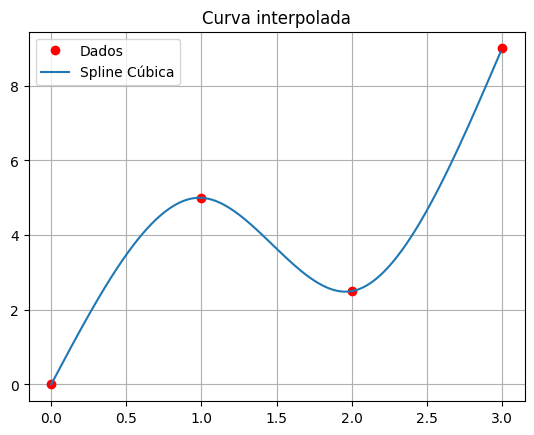

In [45]:
#Gráfico dos pontos considerados e a função interpoladora

#Valores de x e y
x = [0,1,2,3]
y = [0,5,2.5,9]

#Plot dos pontos considerandos para interpolação
plt.plot(x, y, 'ro', label = 'Dados')

#Plot da função Spline
t = np.arange(x[0],x[len(x)-1],0.01) #arange numpy
k = [i for i in t]
z = [Spline_Cubica(x, y, valor = i) for i in t]

plt.plot(k,z, label='Spline Cúbica')

#Caracteristicas dos gráfico
plt.title('Curva interpolada')
plt.grid(True)

plt.legend()
plt.show()

# Caso de comparação

Considerando alguns pontos da função $f(x) = x^{3}+2x^{2}-25x-50 = (x-5)(x+2)(x+5)$ no intervalo $[-5,6]$ construiremos o spline e compararemos com os resultado da função $f(x)$.

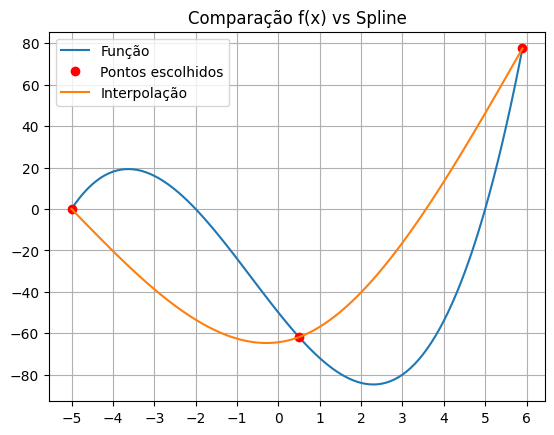

In [46]:
#Função
x = [i for i in np.arange(-5,6,0.1)]
f = [(i+2)*(i-5)*(i+5) for i in x]

#Pontos para interpolação
k = [x[0],x[55],x[109]]
y = [f[0],f[55],f[109]]

#Curva de interpolação
z = [Spline_Cubica(k, y, valor = i) for i in np.arange(-5,6,0.1)]

#Função definida
plt.plot(x,f,label = 'Função')

#Pontos escolhidos
plt.plot(k,y,'ro', label='Pontos escolhidos')

#Curva interpolada
plt.plot(x, z, label='Interpolação')

plt.title('Comparação f(x) vs Spline')
plt.xticks([i for i in range(-5,7)])
plt.grid(True)

plt.legend()
plt.show()

Considerando uma quantidade maior de pontos para modelagem do Spline.

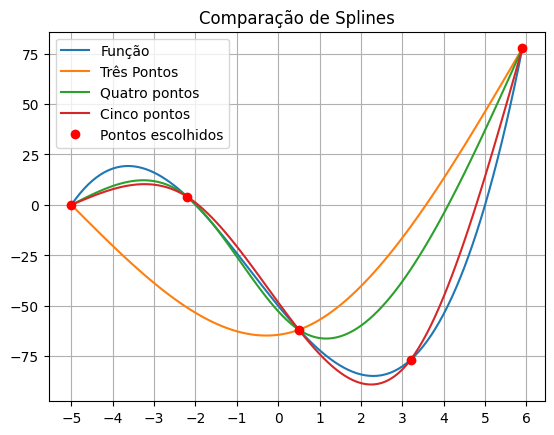

In [47]:
#Função
x = [i for i in np.arange(-5,6,0.1)]
f = [(i+2)*(i-5)*(i+5) for i in x]
plt.plot(x,f,label = 'Função')

#Curva de 3 pontos
k1 = [x[0],x[55],x[109]]
y1 = [f[0],f[55],f[109]]
z1 = [Spline_Cubica(k1, y1, valor = i) for i in np.arange(-5,6,0.1)]
plt.plot(x, z1, label='Três Pontos')

#Curva de 4 pontos
k2 = [x[0],x[28],x[55],x[109]]
y2 = [f[0],f[28],f[55],f[109]]
z2 = [Spline_Cubica(k2, y2, valor = i) for i in np.arange(-5,6,0.1)]
plt.plot(x, z2, label = 'Quatro pontos')

#Curva de 5 pontos
k3 = [x[0],x[28],x[55],x[82],x[109]]
y3 = [f[0],f[28],f[55],f[82],f[109]]
z3 = [Spline_Cubica(k3, y3, valor = i) for i in np.arange(-5,6,0.1)]
plt.plot(x, z3, label = 'Cinco pontos')

#Pontos escolhidos
plt.plot(k3,y3,'ro', label='Pontos escolhidos')

plt.title('Comparação de Splines')
plt.xticks([i for i in range(-5,7)])
plt.grid(True)

plt.legend()
plt.show()

Erro de interpolação absoluto de acordo com os três modelos de splines

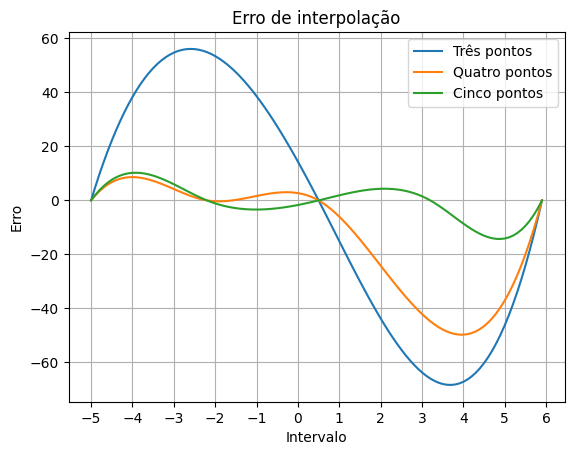

In [48]:
#Erro de interpolação - 03 pontos
erro1 = [f[i] - z[i] for i in range(len(f))]
plt.plot(x, erro1, label = 'Três pontos')

#Erro de interpolação - 04 pontos
k2 = [x[0],x[28],x[55],x[109]]
y2 = [f[0],f[28],f[55],f[109]]
z2 = [Spline_Cubica(k2, y2, valor = i) for i in np.arange(-5,6,0.1)]
erro2 = [f[i] - z2[i] for i in range(len(f))]
plt.plot(x, erro2, label = 'Quatro pontos')

#Erro de interpolação - 05 pontos
k3 = [x[0],x[28],x[55],x[82],x[109]]
y3 = [f[0],f[28],f[55],f[82],f[109]]
z3 = [Spline_Cubica(k3, y3, valor = i) for i in np.arange(-5,6,0.1)]
erro3 = [f[i] - z3[i] for i in range(len(f))]
plt.plot(x, erro3, label = 'Cinco pontos')

#Características dos gráfico
plt.title('Erro de interpolação')
plt.xlabel('Intervalo')
plt.ylabel('Erro')
plt.xticks([i for i in range(-5,7)])
plt.grid(True)

plt.legend()
plt.show()